<a href="https://colab.research.google.com/github/MueezAmj/A2_ML2_Bayes/blob/dev/ML_Assignment_2_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOUNT TO DRIVE**



In [42]:
# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive at the specified location
drive.mount('/content/drive')
!pip install imblearn
!pip install nltk

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORT LIBRARIES**

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Import the necessary modules
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**LOAD DATASET- Train and test datasets**

In [7]:
# Load your preprocessed Excel files
train_data = pd.read_csv('/content/drive/MyDrive/train_sampled.csv')

# Use quoting=3 to tell pandas to ignore quotes
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')



**ASSIGNING X,Y VARIABLES**

In [8]:
# Extract features and labels
X_train = train_data['text']
y_train = train_data['sentiment']
X_test = test_data['text']
y_test = test_data['sentiment']

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
percentages = counts / counts.sum() * 100
class_percentage = dict(zip(unique, percentages))
print(class_percentage)

{-1: 23.08751475269125, 0: 9.89950287901005, 1: 67.01298236829871}


# **Naive Bayes model using One-Hot Vectors for Unigram**

In [10]:
train_data.shape

(55922, 2)

**Vectorization**




In [11]:
# Initialize CountVectorizer for unigrams
vectorizer = CountVectorizer(ngram_range=(1, 1))  # (1, 1) for unigrams

# Fit and transform the training data
X_train_vectors = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vectors = vectorizer.transform(X_test)

# Convert to One-Hot Encoding (binary presence)
X_train_one_hot = (X_train_vectors > 0).astype(int)
X_test_one_hot = (X_test_vectors > 0).astype(int)

**Handle Class Imbalance**

In [12]:
# Define the sampling strategy based on the balanced approach
sampling_strategy = {
    -1: 20000,  # Oversample to 20,000
    0: 20000,   # Oversample to 20,000
    1: 37475    # Keep class 1 as is
}

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_one_hot, y_train)


In [13]:
unique, counts = np.unique(y_train_resampled, return_counts=True)
percentages = counts / counts.sum() * 100
class_percentage = dict(zip(unique, percentages))
print(class_percentage)

{-1: 25.81477896095515, 0: 25.81477896095515, 1: 48.3704420780897}


**Model building**

In [14]:
# Initialize the Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = model.predict(X_test_one_hot)


**Model Evaluation**

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.78      0.75    322657
           0       0.33      0.36      0.34    138383
           1       0.91      0.88      0.89    937016

    accuracy                           0.80   1398056
   macro avg       0.66      0.67      0.66   1398056
weighted avg       0.81      0.80      0.81   1398056



**Accuracy: 0.80**
This means that **80%** of the total predictions were correct. It’s a relatively strong accuracy score, but even after balancing the negative neutral classes we see imbalance.

**Class -1 (Negative reviews):**

Precision: 0.73 – Out of all reviews predicted as negative, 73% were truly negative.
Recall: 0.78 – Out of all actual negative reviews, 78% were correctly classified as negative.
F1-score: 0.75 – A good balance between precision and recall, indicating the model is doing reasonably well with negative reviews.
Support: 322,657 – This is the number of true negative reviews in the test set, showing that the negative class is fairly well-represented.

**Class 0 (Neutral reviews):**

Precision: 0.33 – Out of all reviews predicted as neutral, only 33% were truly neutral. This indicates a lot of false positives in the neutral class.
Recall: 0.36 – Out of all actual neutral reviews, only 36% were correctly predicted as neutral. This indicates that the model struggles to correctly identify neutral reviews.
F1-score: 0.34 – A relatively low score, showing that the model performs poorly for neutral reviews.
Support: 138,383 – There are fewer neutral reviews, which could be contributing to the poorer performance.

**Class 1 (Positive reviews):**

Precision: 0.91 – Out of all reviews predicted as positive, 91% were truly positive. This indicates very few false positives in the positive class.
Recall: 0.88 – Out of all actual positive reviews, 88% were correctly classified as positive. A high recall score means the model is good at identifying positive reviews.
F1-score: 0.89 – A strong score, indicating that the model performs very well on positive reviews.
Support: 937,016 – Positive reviews dominate the dataset, which might explain the model’s better performance in this category.

**Findings**
The model is highly effective at predicting positive reviews (high precision, recall, and F1-score) and performs reasonably well for negative reviews.

The model struggles significantly with the neutral class (low precision, recall, and F1-score). This suggests that neutral reviews are often misclassified as either positive or negative, which may be due to overlapping features between neutral and the other classes.

**Confusion Matrix**

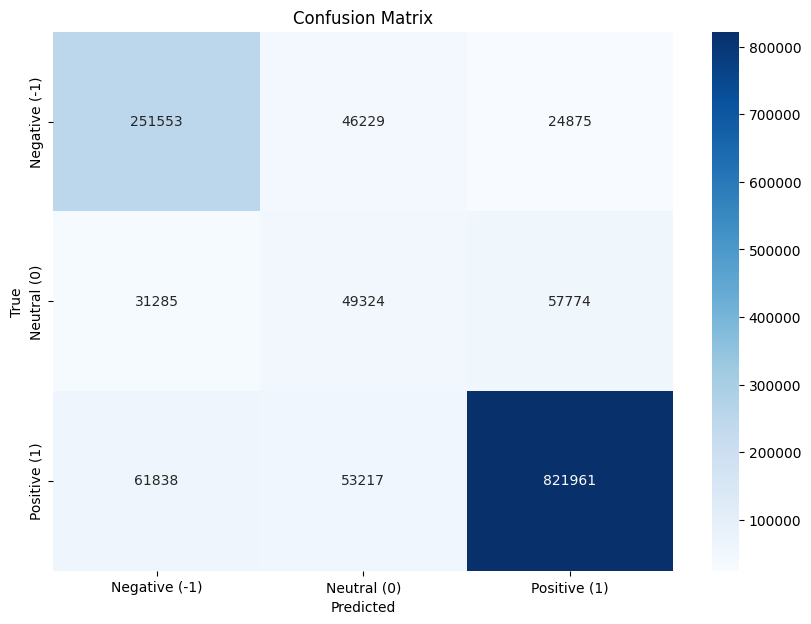

In [16]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Model Performance**:

**Accuracy**: The largest values on the diagonal (251,548, 49,313, and 821,991) show that the model has correctly classified a significant number of reviews, especially for the positive class.

**Error**: However, there are non-negligible misclassifications, especially where neutral reviews are confused with positive reviews (57,781 cases).
The model seems to perform best on identifying positive reviews (with the highest true positive rate), followed by negative reviews, but struggles with classifying neutral reviews (lower accuracy for the neutral class).

**Improvements that can be made**:
The performance can be improved by using better n-grams, word embedding or further tuning of model hyperparameters.

**F1 Score**

In [17]:
# Calculate F1 scores for positive and negative classes
f1_positive = f1_score(y_test, y_pred, pos_label=1,average='macro')
f1_negative = f1_score(y_test, y_pred, pos_label=-1,average='macro')

print(f"F1 Score for Positive Class (1): {f1_positive:.2f}")
print(f"F1 Score for Negative Class (-1): {f1_negative:.2f}")



F1 Score for Positive Class (1): 0.66
F1 Score for Negative Class (-1): 0.66


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to -1) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


**AUC Curve**

<ipython-input-18-d476bbbbfd6b>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', linestyle='--')


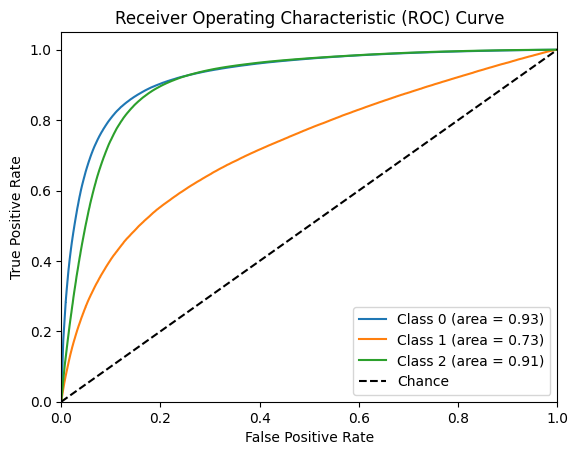

In [18]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_pred_proba = model.predict_proba(X_test_one_hot)

# Calculate AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

# Plotting the AUC
plt.figure()
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **Naive Bayes model using Count Vectors for Unigram+Bigram**
---





**Vectorization**

In [19]:

# Initialize CountVectorizer for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))  # (1, 2) for unigrams and bigrams

# Fit and transform the training data
X_train_vectors_1 = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vectors_1 = vectorizer.transform(X_test)


**Handle Class Imbalance**

In [20]:
# Define the sampling strategy based on the balanced approach
sampling_strategy = {
    -1: 20000,  # Oversample to 20,000
    0: 20000,   # Oversample to 20,000
    1: 37475    # Keep class 1 as is
}

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled_1, y_train_resampled_1 = smote.fit_resample(X_train_vectors_1, y_train)


In [21]:
unique, counts = np.unique(y_train_resampled_1, return_counts=True)
percentages = counts / counts.sum() * 100
class_percentage = dict(zip(unique, percentages))
print(class_percentage)

{-1: 25.81477896095515, 0: 25.81477896095515, 1: 48.3704420780897}


**Model building**

In [22]:
# Initialize the Naive Bayes classifier
model_1 = MultinomialNB()

# Train the model
model_1.fit(X_train_resampled_1, y_train_resampled_1)

# Make predictions on the test data
y_pred_1 = model_1.predict(X_test_vectors_1)

**Model Evaluation**

In [23]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_1)
report = classification_report(y_test, y_pred_1)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.80      0.80    322657
           0       0.46      0.06      0.11    138383
           1       0.85      0.96      0.90    937016

    accuracy                           0.84   1398056
   macro avg       0.71      0.61      0.61   1398056
weighted avg       0.80      0.84      0.80   1398056



**Accuracy: 0.84 (or 84%)**

This indicates that the model correctly classified 84% of the reviews in the dataset. This is a good accuracy score, suggesting that the model performs reasonably well in distinguishing between the different sentiment categories (negative, neutral, and positive)

**Class -1 (Negative):**

Precision: 0.81
This means that among the reviews predicted as negative, 81% were actually negative. This indicates the model is good at identifying negative sentiments.
Recall: 0.80
Out of all actual negative reviews, 80% were correctly identified by the model. This shows that the model captures a large portion of the negative sentiment.F1-Score: 0.80
The F1-score is a harmonic mean of precision and recall, suggesting a strong balance between the two metrics for negative sentiment.

**Class 0 (Neutral):**

Precision: 0.46
This indicates that only 46% of the reviews predicted as neutral were actually neutral, suggesting that the model has difficulty accurately identifying neutral sentiments.
Recall: 0.06
The model only identified 6% of all actual neutral reviews, which is very low. This means that many neutral sentiments are likely being misclassified as either negative or positive.
F1-Score: 0.11
This low F1-score reflects the model's struggle with the neutral class, indicating a significant area for improvement.

**Class 1 (Positive):**

Precision: 0.85
This means that when the model predicts a review is positive, there is an 85% chance it is correct. This indicates a strong performance in identifying positive sentiments.
Recall: 0.96
The model correctly identified 96% of all actual positive reviews, suggesting that it performs very well on this class.
F1-Score: 0.90
The high F1-score for positive sentiment indicates a robust balance between precision and recall.

**Findings**
The model shows strong performance in identifying both negative and positive sentiments, with high precision and recall for these classes.
Particularly, the model excels in correctly identifying positive reviews, achieving a high recall of 96%. At the same time the model struggles significantly with neutral reviews, reflected in the very low precision, recall, and F1-score for this class.
The low recall for neutral sentiment (6%) suggests that the model frequently misclassifies neutral reviews as either positive or negative, leading to confusion in sentiment analysis.

**Imporovemnts that can be made**
We can use More Advanced Techniques: Consider using more sophisticated techniques like word embeddings (Word2Vec, GloVe) or neural networks that can capture semantic meaning better than simple counts.
We can also perform Data Augmentation: If possible, collect or create more neutral reviews to help balance the dataset.
Ensemble Methods: Try combining multiple models (e.g., stacking or voting classifiers) to see if this improves performance on the neutral class.

**Confusion Matrix**

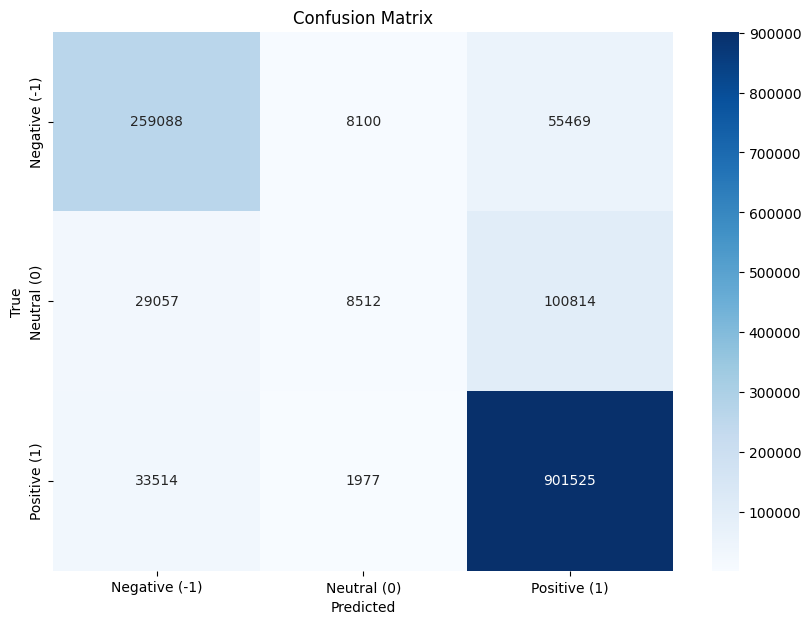

In [24]:
# Compute the confusion matrix
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**F1 Score**

In [25]:
# Calculate F1 scores for positive and negative classes
f1_positive = f1_score(y_test, y_pred_1, pos_label=1,average='macro')
f1_negative = f1_score(y_test, y_pred_1, pos_label=-1,average='macro')

print(f"F1 Score for Positive Class (1): {f1_positive:.2f}")
print(f"F1 Score for Negative Class (-1): {f1_negative:.2f}")

F1 Score for Positive Class (1): 0.61
F1 Score for Negative Class (-1): 0.61


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to -1) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


**AUC Curve**

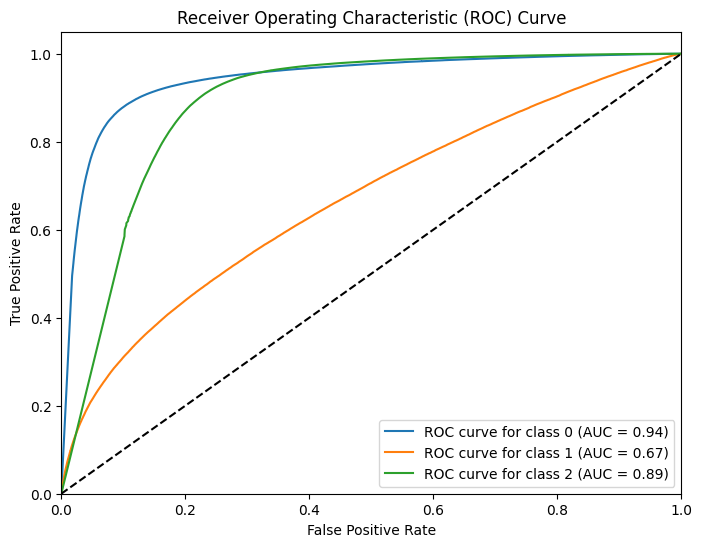

Macro AUC Score: 0.83


In [28]:

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])  # Adjust classes as necessary
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for each class
y_probs_1 = model_1.predict_proba(X_test_vectors_1)

# Compute AUC for each class
auc_score = roc_auc_score(y_test_bin, y_probs_1, average='macro')

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs_1[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_probs_1[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"Macro AUC Score: {auc_score:.2f}")



# **Naive Bayes model using One-Hot Vectors for Unigram+Bigram**

**Vectorization**

In [29]:
# Initialize CountVectorizer for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))  # (1, 2) for unigrams and bigrams

# Fit and transform the training data
X_train_vectors_2 = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vectors_2 = vectorizer.transform(X_test)

# Convert the sparse matrix to a dense format (One-Hot Encoding)
X_train_one_hot_2 = (X_train_vectors > 0).astype(int)
X_test_one_hot_2 = (X_test_vectors > 0).astype(int)

**Handle Class Imbalance**

In [30]:
# Define the sampling strategy based on the balanced approach
sampling_strategy = {
    -1: 20000,  # Oversample to 20,000
    0: 20000,   # Oversample to 20,000
    1: 37475    # Keep class 1 as is
}

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled_2, y_train_resampled_2 = smote.fit_resample(X_train_one_hot_2, y_train)

In [31]:
unique, counts = np.unique(y_train_resampled_2, return_counts=True)
percentages = counts / counts.sum() * 100
class_percentage = dict(zip(unique, percentages))
print(class_percentage)

{-1: 25.81477896095515, 0: 25.81477896095515, 1: 48.3704420780897}


**Model Building**

In [33]:
# Initialize the Naive Bayes classifier
model_2 = MultinomialNB()

# Train the model
model_2.fit(X_train_one_hot_2, y_train)

# Make predictions on the test data
y_pred_2 = model_2.predict(X_test_one_hot_2)

**Model Evaluation**



In [34]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_2)
report = classification_report(y_test, y_pred_2)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

          -1       0.74      0.78      0.76    322657
           0       0.39      0.20      0.27    138383
           1       0.88      0.92      0.90    937016

    accuracy                           0.82   1398056
   macro avg       0.67      0.64      0.64   1398056
weighted avg       0.80      0.82      0.81   1398056



**Accuracy: 0.82 (or 82%)**
Here we can see that the model correctly classified 82% of the total instances in the dataset. This is a relatively good accuracy score, indicating that the model is generally effective at classifying the reviews into their respective sentiment categories.

**Class -1 (Negative):**

Precision: 0.74
This means that of all the reviews predicted as negative, 74% were actually negative.
Recall: 0.78
Out of all actual negative reviews, 78% were correctly identified by the model.
F1-Score: 0.76
This is the harmonic mean of precision and recall, indicating a balance between the two. A score of 0.76 is reasonably good.

**Class 0 (Neutral):**

Precision: 0.39
Only 39% of the reviews predicted as neutral were actually neutral, indicating that the model struggles to accurately predict neutral sentiments.
Recall: 0.20
The model only identified 20% of all actual neutral reviews, which is quite low.
F1-Score: 0.27
This low score reflects the model’s difficulty in predicting neutral sentiments, indicating a significant area for improvement.

**Class 1 (Positive):**

Precision: 0.88
This means that when the model predicts a review is positive, there is an 88% chance it is correct.
Recall: 0.92
The model correctly identified 92% of all actual positive reviews, indicating it performs very well on this class.
F1-Score: 0.90
A high F1-score for positive sentiment indicates a strong balance between precision and recall.


**Findings**

The model performs well in predicting positive reviews with high precision and recall. This suggests that it has effectively learned the characteristics of positive sentiment in the data.
at the same time the model struggles significantly with neutral reviews, indicated by low precision and recall scores. This is a critical issue since it may misclassify neutral reviews as either positive or negative, leading to confusion in sentiment analysis.

**Possible next steps to increase accuracy**

Feature Engineering: Consider additional features that may help distinguish neutral sentiments from positive and negative ones (e.g., sentiment lexicons, emoticons, or context-specific features).
Hyperparameter Tuning: Experiment with different settings for the Naive Bayes model to see if performance can be improved.
Data Augmentation: If possible, collect or generate more examples of neutral reviews to help balance the dataset.

**Confusion Matrix**

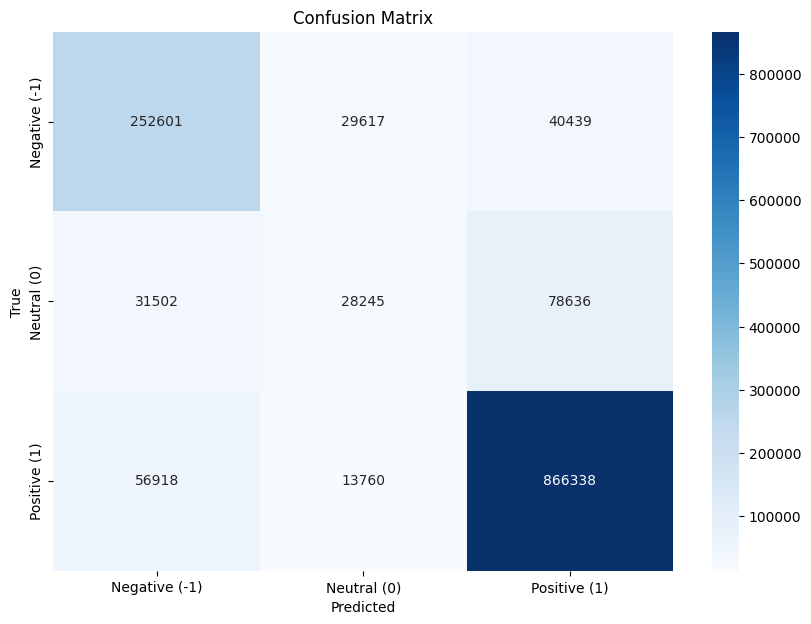

In [38]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_2)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**F1 Score**

In [39]:
# Calculate F1 scores for positive and negative classes
f1_positive = f1_score(y_test, y_pred_2, pos_label=1,average='macro')
f1_negative = f1_score(y_test, y_pred_2, pos_label=-1,average='macro')

print(f"F1 Score for Positive Class (1): {f1_positive:.2f}")
print(f"F1 Score for Negative Class (-1): {f1_negative:.2f}")

F1 Score for Positive Class (1): 0.64
F1 Score for Negative Class (-1): 0.64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to -1) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


**AUC Curve**

<ipython-input-40-d9b6a37591c4>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', linestyle='--')


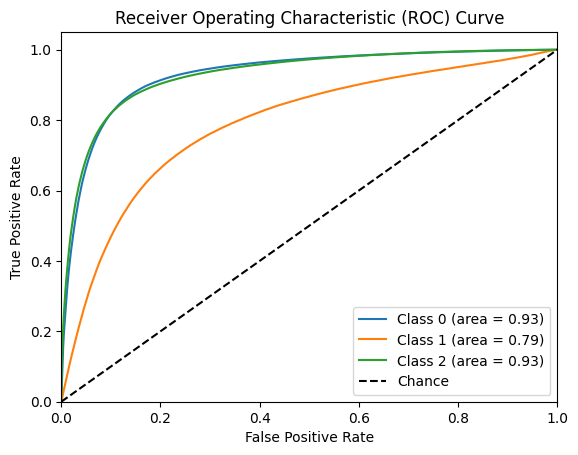

In [40]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_pred_proba = model_2.predict_proba(X_test_one_hot_2)

# Calculate AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

# Plotting the AUC
plt.figure()
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()